In [1]:
import math
import torch
from torch import nn
from Dive_into_deep_learning.d2l import torch as d2l

batch_size, max_window_size, num_noise_words = 512, 5, 5
data_iter, vocab = d2l.load_data_ptb(batch_size, max_window_size,
                                     num_noise_words)

In [2]:
embed = nn.Embedding(num_embeddings=20, embedding_dim=4)
print(f'Parameter embedding_weight ({embed.weight.shape}, '
      f'dtype={embed.weight.dtype})')

Parameter embedding_weight (torch.Size([20, 4]), dtype=torch.float32)


In [3]:
x = torch.tensor([[1, 2, 3], [4, 5, 6]])
embed(x)

tensor([[[ 0.2967, -1.4555,  0.4222, -0.0493],
         [-1.6907,  0.7761, -1.1570, -0.1370],
         [ 0.8232,  1.7794,  2.0764, -0.8761]],

        [[-1.7901, -0.6370,  0.5749, -0.1540],
         [ 0.3648,  1.9149,  0.6118, -0.4601],
         [ 0.9988, -0.6403,  1.3119,  0.5785]]], grad_fn=<EmbeddingBackward0>)

In [4]:
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    v = embed_v(center)
    u = embed_u(contexts_and_negatives)
    pred = torch.bmm(v, u.permute(0, 2, 1))
    return pred

skip_gram(torch.ones((2, 1), dtype=torch.long), 
          torch.ones((2, 4), dtype=torch.long), embed, embed).shape

torch.Size([2, 1, 4])

In [5]:
class SigmoidBCELoss(nn.Module):
    # Binary cross-entropy loss with masking
    def __init__(self):
        super().__init__()
        
    def forward(self, inputs, target, mask=None):
        out = nn.functional.binary_cross_entropy_with_logits(
            inputs, target, weight=mask, reduction="none")
        return out.mean(dim=1)

loss = SigmoidBCELoss()

In [6]:
pred = torch.tensor([[1.1, -2.2, 3.3, -4.4]] * 2)
label = torch.tensor([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0]])
mask = torch.tensor([[1, 1, 1, 1], [1, 1, 0, 0]])
loss(pred, label, mask) * mask.shape[1] / mask.sum(axis=1)

tensor([0.9352, 1.8462])

In [7]:
def sigmd(x):
    return -math.log(1 / (1 + math.exp(-x)))

print(f'{(sigmd(1.1) + sigmd(2.2) + sigmd(-3.3) + sigmd(4.4)) / 4:.4f}')
print(f'{(sigmd(-1.1) + sigmd(-2.2)) / 2:.4f}')

0.9352
1.8462


In [8]:
embed_size = 100
net = nn.Sequential(nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=embed_size),
                    nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=embed_size))

In [9]:
net[0]

Embedding(6719, 100)

In [10]:
def train(net, data_iter, lr, num_epochs, device=d2l.try_gpu()):
    def init_weights(module):
        if type(module) == nn.Embedding:
            nn.init.xavier_uniform_(module.weight)
    net.apply(init_weights)
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, num_epochs])
    # Sum of normalized losses, no. of normalized losses
    metric = d2l.Accumulator(2)
    for epoch in range(num_epochs):
        timer, num_batches = d2l.Timer(), len(data_iter)
        for i, batch in enumerate(data_iter):
            optimizer.zero_grad()
            center, context_negative, mask, label = [
                data.to(device) for data in batch]
            
            pred = skip_gram(center, context_negative, net[0], net[1])
            l = (loss(pred.reshape(label.shape).float(), label.float(), mask)
                 / mask.sum(axis=1) * mask.shape[1])
            l.sum().backward()
            optimizer.step()
            metric.add(l.sum(), l.numel())
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1], ))
    print(f'loss {metric[0] / metric[1]:.3f}, '
          f'{metric[1] / timer.stop():.1f} tokens/sec on {str(device)}')


loss 0.410, 91158.6 tokens/sec on cpu


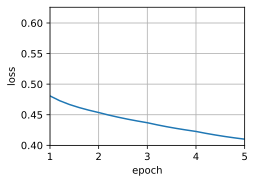

In [11]:
lr, num_epochs = 0.002, 5
train(net, data_iter, lr, num_epochs)

# Applying Word Embeddings

In [14]:
def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data
    x = W[vocab[query_token]]
    # Compute the cosine similarity. Add 1e-9 for numerical stability
    cos = torch.mv(W, x) / torch.sqrt(torch.sum(W * W, dim=1) *
                                      torch.sum(x * x) + 1e-9)
    topk = torch.topk(cos, k=k+1)[1].cpu().numpy().astype('int32')
    for i in topk[1:]:  # Remove the input words
        print(f'cosine sim={float(cos[i]):.3f}: {vocab.to_tokens(i)}')

get_similar_tokens('chip', 3, net[0])

cosine sim=0.703: microprocessor
cosine sim=0.663: intel
cosine sim=0.633: bull


In [17]:
get_similar_tokens('cancer', 3, net[0])

cosine sim=0.731: colon
cosine sim=0.697: lung
cosine sim=0.660: cancers


In [18]:
w = torch.empty(3, 5)
w

tensor([[3.5733e-43, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]])

In [19]:
w2 = nn.init.normal_(w)

In [20]:
w2

tensor([[-0.0744, -0.4529, -1.4064,  0.0615, -1.9141],
        [-0.0226, -0.1537, -0.8905, -0.7818, -0.2335],
        [ 0.2546,  1.0772, -0.2881, -1.1716,  0.7462]])

In [22]:
# dim越大，均值、方差越接近0和1
dim = 800000
# 定义了一个(5, dim)的二维embdding
# 对于NLP来说，相当于是5个词，每个词的词向量维数是dim
# 每个词向量初始化为正态分布 N(0,1)（待验证）
embd = nn.Embedding(5, dim)
# type(embd.weight) is Parameter
# type(embd.weight.data) is Tensor
# embd.weight.data[0]是指(5, dim)的word embeddings中取第1个词的词向量，是dim维行向量

for i in range(5):
    weight = embd.weight.data[i].numpy()
    print(f'第{i}个词')
    print("weight: {}".format(weight))
    
    weight_sum = 0
    for w in weight:
        weight_sum += w
    mean = weight_sum / dim
    print("均值: {}".format(mean))
    
    square_sum = 0
    for w in weight:
        square_sum += (mean - w) ** 2
    print("方差: {}".format(square_sum / dim))

第0个词
weight: [-1.3170025 -1.066348  -1.1682675 ...  1.5839298  0.6103728 -0.0361993]
均值: 5.2717730953146145e-05
方差: 1.0014495397464034
第1个词
weight: [ 1.3632039  1.8291643 -1.0573055 ...  1.2204473  1.1705498  0.53595  ]
均值: -0.0020197855591735352
方差: 0.9995498259684724
第2个词
weight: [ 0.31369305 -0.6967513  -1.124912   ... -0.13410182  1.2455823
  0.04349519]
均值: -0.0009159357544122181
方差: 1.002411075493613
第3个词
weight: [-1.1316485   0.35321838  0.43719783 ... -1.1679306  -0.09301543
 -0.08706333]
均值: -0.0021262392792894165
方差: 0.9987310349182694
第4个词
weight: [-0.2516945   0.27649638  1.9232883  ... -0.29700333  1.0924253
 -0.50739163]
均值: -0.0010932263851590638
方差: 0.9988357006752373


In [26]:
dim = 800000
embed = nn.Embedding(10, dim)
weights = embed.weight.data
means = torch.mean(weights, dim=-1)
stds = torch.std(weights, dim=-1)

In [32]:
means

tensor([ 2.6338e-04,  1.9700e-04, -4.8454e-04, -3.9913e-04, -2.8231e-04,
        -3.3660e-04, -1.0057e-04, -5.6082e-04, -4.6355e-06,  3.3902e-05])

In [29]:
stds

tensor([1.0002, 1.0000, 1.0002, 0.9996, 0.9996, 0.9999, 1.0000, 1.0002, 1.0001,
        0.9997])

In [33]:
torch.cat((means[:, None], stds[:, None]), dim=-1)

tensor([[ 2.6338e-04,  1.0002e+00],
        [ 1.9700e-04,  1.0000e+00],
        [-4.8454e-04,  1.0002e+00],
        [-3.9913e-04,  9.9964e-01],
        [-2.8231e-04,  9.9963e-01],
        [-3.3660e-04,  9.9990e-01],
        [-1.0057e-04,  9.9996e-01],
        [-5.6082e-04,  1.0002e+00],
        [-4.6355e-06,  1.0001e+00],
        [ 3.3902e-05,  9.9969e-01]])

In [34]:
means2 = torch.mean(weights, dim=0)
stds2 = torch.std(weights, dim=0)
torch.cat((means[:, None], stds[:, None]), dim=-1)

tensor([[ 2.6338e-04,  1.0002e+00],
        [ 1.9700e-04,  1.0000e+00],
        [-4.8454e-04,  1.0002e+00],
        [-3.9913e-04,  9.9964e-01],
        [-2.8231e-04,  9.9963e-01],
        [-3.3660e-04,  9.9990e-01],
        [-1.0057e-04,  9.9996e-01],
        [-5.6082e-04,  1.0002e+00],
        [-4.6355e-06,  1.0001e+00],
        [ 3.3902e-05,  9.9969e-01]])

In [35]:
means3 = torch.mean(weights)
stds3 = torch.std(weights)
means3, stds3

(tensor(-0.0002), tensor(1.0000))

In [36]:
weights

tensor([[ 2.0245,  0.4366,  0.3038,  ...,  0.3996, -2.7156,  0.2059],
        [-0.9879, -0.3332,  1.3540,  ...,  0.1122, -0.7258,  0.0335],
        [-1.3183,  1.1306, -0.1846,  ..., -0.2577,  0.6777,  2.3300],
        ...,
        [ 0.1378, -1.3960, -1.3548,  ..., -0.5636, -0.0770, -0.7595],
        [ 0.3764, -0.7610, -0.0294,  ..., -0.9057,  1.5630,  1.5961],
        [ 0.7289, -0.1739,  0.3803,  ...,  0.3215, -0.5126, -0.1776]])

In [ ]:
# Transformer处 x sqrt(d) ?
# embed.weight.data ~ N(0, 1)